# Hybrid AutoRec-NCF for Rating Prediction (Explicit Feedback)

## Motivation

This notebook adapts the Hybrid AutoRec-NCF model for **explicit feedback** rating prediction tasks.

### Key Features:

1. **Data**: Actual ratings (1-5 scale)
2. **Loss**: MSE loss for regression
3. **No Negative Sampling**: Use all ratings directly
4. **Evaluation**: RMSE and MAE metrics

### Approach:

- Use actual ratings (1-5 scale)
- Train with mean squared error loss
- Evaluate using RMSE and MAE metrics

---

## Architecture Overview: Decoder vs NCF

### Important Distinction

**Decoder** and **NCF** serve different roles:

1. **Decoder (Reconstruction Task)**:
   - Input: `user_z` (latent representation)
   - Output: `user_recon` (full rating vector for ALL items)
   - Purpose: Learn good representations (unsupervised)
   - Example: Predicts ratings for items [0, 1, 2, ..., 3705] for user 42

2. **NCF (Prediction Task)**:
   - Input: `user_z` + `item_z` (both latent representations)
   - Output: `pred` (single rating for ONE user-item pair)
   - Purpose: Make accurate predictions (supervised)
   - Example: Predicts rating(42, 789) = 4.2

**Why both?**
- Decoder ensures the encoder learns meaningful patterns (reconstruction loss)
- NCF combines user and item representations for accurate predictions (interaction loss)
- They complement each other: decoder learns features, NCF uses them for prediction

# Hybrid AutoRec-NCF for Rating Prediction (Explicit Feedback)

## Motivation

This notebook adapts the Hybrid AutoRec-NCF model for **explicit feedback** rating prediction tasks.

### Key Features:

1. **Data**: Actual ratings (1-5 scale)
2. **Loss**: MSE loss for regression
3. **No Negative Sampling**: Use all ratings directly
4. **Evaluation**: RMSE and MAE metrics

### Approach:

- Use actual ratings (1-5 scale)
- Train with mean squared error loss
- Evaluate using RMSE and MAE metrics

In [1]:
import os
import sys

current_dir = os.getcwd()

# Walk up the directory tree until we find 'src'
path = current_dir
src_path = None

while True:
    if os.path.basename(path) == "src":
        src_path = path
        break
    parent = os.path.dirname(path)
    if parent == path:  # reached filesystem root
        break
    path = parent

# Add src to sys.path if found
if src_path and src_path not in sys.path:
    sys.path.insert(0, src_path)


import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Local imports
from helpers.data_downloader import download_ml1m_dataset

torch.manual_seed(42)
np.random.seed(42)

/Users/abbas/Documents/Codes/thesis/recommender/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class AutoEncoder(nn.Module):
    def __init__(
        self,
        input_dim: int,
        latent_dim: int,
        hidden_dims=(256, 128),
        dropout_rate: float = 0.1,
    ):
        """
        Args:
            input_dim: dimensionality of input vector (e.g. user rating vector)
            latent_dim: size of bottleneck (MUST match NCF latent_dim)
            hidden_dims: encoder hidden layer sizes
            dropout_rate: dropout applied to hidden layers
        """
        super().__init__()

        # =======================
        # Encoder
        # =======================
        encoder_layers = []
        prev_dim = input_dim

        for h in hidden_dims:
            encoder_layers.append(nn.Linear(prev_dim, h))
            encoder_layers.append(nn.ReLU())
            encoder_layers.append(nn.Dropout(dropout_rate))
            prev_dim = h

        # Bottleneck (NO activation)
        encoder_layers.append(nn.Linear(prev_dim, latent_dim))
        self.encoder = nn.Sequential(*encoder_layers)

        # =======================
        # Decoder
        # =======================
        decoder_layers = []
        prev_dim = latent_dim

        for h in reversed(hidden_dims):
            decoder_layers.append(nn.Linear(prev_dim, h))
            decoder_layers.append(nn.ReLU())
            decoder_layers.append(nn.Dropout(dropout_rate))
            prev_dim = h

        decoder_layers.append(nn.Linear(prev_dim, input_dim))
        # No activation for rating prediction (raw reconstruction)

        self.decoder = nn.Sequential(*decoder_layers)

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        recon = self.decode(z)
        return recon, z

In [3]:
class NCF(nn.Module):
    def __init__(
        self,
        latent_dim,
        mlp_layers=(128, 64),
        dropout_rate=0.1,
    ):
        super().__init__()

        # =======================
        # GMF (pure interaction)
        # =======================
        # No parameters here by design

        # =======================
        # MLP
        # =======================
        mlp_modules = []
        input_dim = latent_dim * 2

        for h in mlp_layers:
            mlp_modules.append(nn.Linear(input_dim, h))
            mlp_modules.append(nn.ReLU())
            mlp_modules.append(nn.Dropout(dropout_rate))
            input_dim = h

        self.mlp = nn.Sequential(*mlp_modules)

        # =======================
        # Final prediction layer
        # =======================
        mlp_out_dim = mlp_layers[-1] if len(mlp_layers) > 0 else input_dim
        self.output = nn.Linear(latent_dim + mlp_out_dim, 1)

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, user_z, item_z):
        # GMF branch
        gmf_out = user_z * item_z  # pure element-wise product

        # MLP branch
        mlp_input = torch.cat([user_z, item_z], dim=1)
        mlp_out = self.mlp(mlp_input)

        # Final prediction
        concat = torch.cat([gmf_out, mlp_out], dim=1)
        pred = self.output(concat)

        # Return raw prediction (use MSE loss)
        return pred.squeeze(-1)

In [4]:
class HybridAutoRecNCF(nn.Module):
    def __init__(self, num_users, num_items, latent_dim, mlp_layers):
        super().__init__()

        self.user_autorec = AutoEncoder(num_items, latent_dim)
        self.item_autorec = AutoEncoder(num_users, latent_dim)

        self.ncf = NCF(latent_dim, mlp_layers)

    def forward(self, user_vecs, item_vecs, user_ids, item_ids):
        # AutoRec forward
        # user_vecs: (batch_size, num_items) - each row is a user's rating vector
        # item_vecs: (batch_size, num_users) - each row is an item's rating vector
        user_recon, user_z = self.user_autorec(user_vecs)
        item_recon, item_z = self.item_autorec(item_vecs)

        # Each element in the batch corresponds to a (user, item) pair
        # user_z[i] is the latent for the user in pair i
        # item_z[i] is the latent for the item in pair i
        pred = self.ncf(user_z, item_z)
        return pred, user_recon, item_recon

In [5]:
def reconstruction_loss(pred, target, mask):
    """MSE loss for reconstruction (explicit ratings)"""
    diff = (pred - target) * mask
    return torch.sum(diff ** 2) / torch.sum(mask)


def interaction_loss(pred, rating):
    """MSE loss for interaction prediction"""
    return F.mse_loss(pred, rating)


def total_loss(pred, rating,
               user_recon, user_vecs, user_mask,
               item_recon, item_vecs, item_mask,
               alpha=1.0, beta=1.0):
    rec_u = reconstruction_loss(user_recon, user_vecs, user_mask)
    rec_i = reconstruction_loss(item_recon, item_vecs, item_mask)
    inter = interaction_loss(pred, rating)
    return alpha * (rec_u + rec_i) + beta * inter

In [6]:
def train(model, dataloader, optimizer, device):
    model.train()
    total = 0.0

    for batch in dataloader:
        (user_ids, item_ids, ratings,
         user_vecs, item_vecs,
         user_mask, item_mask) = batch

        user_ids = user_ids.to(device).squeeze()
        item_ids = item_ids.to(device).squeeze()
        ratings = ratings.to(device).squeeze()
        user_vecs = user_vecs.to(device)
        item_vecs = item_vecs.to(device)
        user_mask = user_mask.to(device)
        item_mask = item_mask.to(device)

        optimizer.zero_grad()

        pred, user_recon, item_recon = model(
            user_vecs, item_vecs, user_ids, item_ids
        )

        loss = total_loss(
            pred, ratings,
            user_recon, user_vecs, user_mask,
            item_recon, item_vecs, item_mask
        )

        loss.backward()
        optimizer.step()
        total += loss.item()

    return total / len(dataloader)

In [7]:
# Load data
data_dir = os.path.join(os.path.dirname(os.getcwd()), '..', 'data')
data_path = os.path.join(data_dir, 'ml-1m', 'ratings.dat')

# Check if file exists
if not os.path.exists(data_path):
    download_ml1m_dataset(data_dir=data_dir)

def load_ml_1m_data(data_path=data_path) -> pd.DataFrame:
    print("=" * 70)
    print("Loading MovieLens 1M Dataset")
    print("=" * 70)
    print(f"Data path: {data_path}")
    return pd.read_csv(
        data_path,
        sep='::',
        header=None,
        names=['user_id', 'item_id', 'rating', 'timestamp'],
        engine='python',
        dtype={
            'user_id': np.int32,
            'item_id': np.int32,
            'rating': np.float32,
            'timestamp': np.int32
        }
    )


# Load ratings data
print("\nLoading ratings data...")
ratings_df = load_ml_1m_data()
print(f"✓ Successfully loaded {len(ratings_df):,} ratings")
print("=" * 70)


Loading ratings data...
Loading MovieLens 1M Dataset
Data path: /Users/abbas/Documents/Codes/thesis/recommender/src/../data/ml-1m/ratings.dat
✓ Successfully loaded 1,000,209 ratings


In [ ]:
# Data preprocessing: remap IDs and create train/test split
def preprocess_data(ratings_df, test_size=0.2, random_state=42):
    """Preprocess data: remap IDs to be contiguous and split train/test"""
    # Create a copy
    data = ratings_df.copy()
    
    # Remap user IDs to be contiguous (0-indexed)
    unique_users = sorted(data['user_id'].unique())
    user_map = {old_id: new_id for new_id, old_id in enumerate(unique_users)}
    data['user_id'] = data['user_id'].map(user_map)
    num_users = len(unique_users)
    
    # Remap item IDs to be contiguous (0-indexed)
    unique_items = sorted(data['item_id'].unique())
    item_map = {old_id: new_id for new_id, old_id in enumerate(unique_items)}
    data['item_id'] = data['item_id'].map(item_map)
    num_items = len(unique_items)
    
    # Split into train and test
    train_df, test_df = train_test_split(
        data[['user_id', 'item_id', 'rating']],
        test_size=test_size,
        random_state=random_state
    )
    
    # Create rating matrices
    train_mat = np.zeros((num_users, num_items), dtype=np.float32)
    test_mat = np.zeros((num_users, num_items), dtype=np.float32)
    
    # Fill train matrix
    for _, row in train_df.iterrows():
        train_mat[int(row['user_id']), int(row['item_id'])] = float(row['rating'])
    
    # Fill test matrix
    for _, row in test_df.iterrows():
        test_mat[int(row['user_id']), int(row['item_id'])] = float(row['rating'])
    
    return train_mat, test_mat, train_df, test_df, num_users, num_items

print("Preprocessing data...")
train_mat, test_mat, train_df, test_df, num_users, num_items = preprocess_data(
    ratings_df, test_size=0.2, random_state=42
)

print(f"✓ Preprocessing complete!")
print(f"  - Users: {num_users}, Items: {num_items}")
print(f"  - Train interactions: {len(train_df):,}")
print(f"  - Test interactions: {len(test_df):,}")
print("=" * 70)

Preprocessing data...


In [ ]:
# Dataset class for hybrid model
class HybridDataset(data.Dataset):
    def __init__(self, rating_matrix, interactions_df):
        """
        Args:
            rating_matrix: (num_users, num_items) rating matrix
            interactions_df: DataFrame with columns ['user_id', 'item_id', 'rating']
        """
        self.rating_matrix = rating_matrix
        self.interactions_df = interactions_df.reset_index(drop=True)
        
        # Create masks (1 where rating exists, 0 otherwise)
        self.user_mask = (rating_matrix > 0).astype(np.float32)
        self.item_mask = (rating_matrix.T > 0).astype(np.float32)  # Transpose for items
    
    def __len__(self):
        return len(self.interactions_df)
    
    def __getitem__(self, idx):
        row = self.interactions_df.iloc[idx]
        user_id = int(row['user_id'])
        item_id = int(row['item_id'])
        rating = float(row['rating'])
        
        # Get user vector (ratings across all items)
        user_vec = torch.FloatTensor(self.rating_matrix[user_id])
        
        # Get item vector (ratings across all users)
        item_vec = torch.FloatTensor(self.rating_matrix[:, item_id])
        
        # Get masks
        user_mask = torch.FloatTensor(self.user_mask[user_id])
        item_mask = torch.FloatTensor(self.item_mask[item_id])
        
        return (
            torch.LongTensor([user_id]),
            torch.LongTensor([item_id]),
            torch.FloatTensor([rating]),
            user_vec,
            item_vec,
            user_mask,
            item_mask
        )

# Create datasets
train_dataset = HybridDataset(train_mat, train_df)
# IMPORTANT: Use train_mat for test_dataset to prevent data leakage
# User/item vectors should only contain training data, not test ratings
test_dataset = HybridDataset(train_mat, test_df)

print(f"✓ Datasets created")
print(f"  - Train samples: {len(train_dataset):,}")
print(f"  - Test samples: {len(test_dataset):,}")
print(f"  - Note: Test dataset uses train_mat to prevent data leakage")


✓ Datasets created
  - Train samples: 800,167
  - Test samples: 200,042


In [ ]:
# Create data loaders
batch_size = 256
train_loader = data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)

test_loader = data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)

print(f"✓ Data loaders created (batch_size={batch_size})")

✓ Data loaders created (batch_size=256)


In [ ]:
# Initialize model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

latent_dim = 64
mlp_layers = [128, 64]

model = HybridAutoRecNCF(
    num_users, num_items, latent_dim, mlp_layers
).to(device)

optimizer = torch.optim.Adam(
    model.parameters(), lr=1e-3, weight_decay=1e-5
)

print(f"✓ Model initialized")
print(f"  - Latent dim: {latent_dim}")
print(f"  - MLP layers: {mlp_layers}")
print(f"  - Total parameters: {sum(p.numel() for p in model.parameters()):,}")

Using device: cpu
✓ Model initialized
  - Latent dim: 64
  - MLP layers: [128, 64]
  - Total parameters: 5,190,099


In [ ]:
# Evaluation function for RMSE and MAE
def evaluate(model, dataloader, device, return_predictions=False):
    model.eval()
    accumulated_loss = 0.0
    accumulated_rmse = 0.0
    accumulated_mae = 0.0
    num_samples = 0
    
    all_preds = []
    all_ratings = []
    
    with torch.no_grad():
        for batch in dataloader:
            (user_ids, item_ids, ratings,
             user_vecs, item_vecs,
             user_mask, item_mask) = batch

            user_ids = user_ids.to(device).squeeze()
            item_ids = item_ids.to(device).squeeze()
            ratings = ratings.to(device).squeeze()
            user_vecs = user_vecs.to(device)
            item_vecs = item_vecs.to(device)
            user_mask = user_mask.to(device)
            item_mask = item_mask.to(device)

            pred, user_recon, item_recon = model(
                user_vecs, item_vecs, user_ids, item_ids
            )

            loss = total_loss(
                pred, ratings,
                user_recon, user_vecs, user_mask,
                item_recon, item_vecs, item_mask
            )
            
            # Calculate RMSE and MAE for predictions
            rmse = torch.sqrt(F.mse_loss(pred, ratings))
            mae = F.l1_loss(pred, ratings)
            
            accumulated_loss += loss.item() * len(ratings)
            accumulated_rmse += rmse.item() * len(ratings)
            accumulated_mae += mae.item() * len(ratings)
            num_samples += len(ratings)
            
            if return_predictions:
                all_preds.extend(pred.cpu().numpy())
                all_ratings.extend(ratings.cpu().numpy())
    
    if return_predictions:
        return (accumulated_loss / num_samples, accumulated_rmse / num_samples, 
                accumulated_mae / num_samples, np.array(all_preds), np.array(all_ratings))
    else:
        return accumulated_loss / num_samples, accumulated_rmse / num_samples, accumulated_mae / num_samples

In [ ]:
# Training loop with metrics tracking and early stopping
num_epochs = 50
best_test_rmse = float('inf')
best_epoch = 0
EARLY_STOPPING_PATIENCE = 10  # Number of epochs to wait before early stopping
patience_counter = 0
MIN_DELTA = 0.0001

# Create model save directory
model_dir = os.path.join(os.path.dirname(os.getcwd()), '..', 'models')
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, 'HybridAutoRecNCF-Rating.pth')

# Track metrics for visualization
training_history = {
    'epoch': [],
    'train_loss': [],
    'test_loss': [],
    'test_rmse': [],
    'test_mae': []
}

print("=" * 70)
print("Starting Training")
print("=" * 70)
print(f"Max Epochs: {num_epochs}")
print(f"Early Stopping Patience: {EARLY_STOPPING_PATIENCE}")
print(f"Batch size: {batch_size}")
try:
    lr = optimizer.param_groups[0]['lr']
    print(f"Learning rate: {lr}")
except NameError:
    print("Learning rate: 0.001 (default)")
print("=" * 70)

epoch_pbar = tqdm(range(num_epochs), desc="Epochs")
for epoch in epoch_pbar:
    # Training
    train_loss = train(model, train_loader, optimizer, device)
    
    # Evaluation (RMSE and MAE)
    test_loss, test_rmse, test_mae = evaluate(model, test_loader, device)
    
    # Early stopping check with minimum delta
    improved = False
    if test_rmse < best_test_rmse - MIN_DELTA:
        best_test_rmse = test_rmse
        best_epoch = epoch
        patience_counter = 0
        improved = True
        torch.save(model.state_dict(), model_path)
    else:
        patience_counter += 1
    
    # Track metrics
    training_history['epoch'].append(epoch + 1)
    training_history['train_loss'].append(train_loss)
    training_history['test_loss'].append(test_loss)
    training_history['test_rmse'].append(test_rmse)
    training_history['test_mae'].append(test_mae)
    
    # Update epoch progress bar
    epoch_pbar.set_postfix({
        'train_loss': f'{train_loss:.4f}',
        'test_rmse': f'{test_rmse:.4f}',
        'test_mae': f'{test_mae:.4f}',
        'best_rmse': f'{best_test_rmse:.4f}',
        'patience': f'{patience_counter}/{EARLY_STOPPING_PATIENCE}'
    })
    
    # Early stopping
    if patience_counter >= EARLY_STOPPING_PATIENCE:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        print(f"No improvement for {EARLY_STOPPING_PATIENCE} epochs")
        break

epoch_pbar.close()

print("=" * 70)
print("Training Complete!")
print(f"Best model at epoch {best_epoch+1} with RMSE: {best_test_rmse:.4f}")
print(f"Model saved to: {model_path}")
print("=" * 70)

Starting Training
Max Epochs: 50
Early Stopping Patience: 10
Batch size: 256
Learning rate: 0.001


Epochs:  40%|████      | 20/50 [52:39<1:18:58, 157.95s/it, train_loss=1.2513, test_rmse=1.0677, test_mae=0.8906, best_rmse=1.0323, patience=10/10]


Early stopping triggered at epoch 21
No improvement for 10 epochs
Training Complete!
Best model at epoch 11 with RMSE: 1.0323
Model saved to: /Users/abbas/Documents/Codes/thesis/recommender/src/../models/HybridAutoRecNCF-Rating.pth


Loading Best Model for Reconstruction Evaluation
✓ Model loaded from: /Users/abbas/Documents/Codes/thesis/recommender/src/../models/HybridAutoRecNCF-Rating.pth

Evaluating Rating Reconstruction Quality...



Reconstruction Evaluation Results:
User Reconstruction:
  - RMSE: 0.9796
  - MAE:  0.7834
  - Users evaluated: 999

Item Reconstruction:
  - RMSE: 1.0083
  - MAE:  0.8176
  - Items evaluated: 928

SAMPLE RATING RECONSTRUCTIONS — User & Item Reconstruction
User     Item     Actual     User Recon   Item Recon  
----------------------------------------------------------------------
2856     2078     4          3.73         3.14        
1171     2505     3          2.82         3.56        
5375     3439     5          4.31         3.67        
4361     239      5          4.12         4.02        
2196     239      4          4.17         3.91        
4116     1581     4          4.19         4.14        
5951     527      4          4.10         4.37        
455      851      3          4.44         3.30        
5635     63       1          1.70         1.71        
2240     875      5          4.22         4.15        
2236     2552     4          3.67         3.96        
345      839

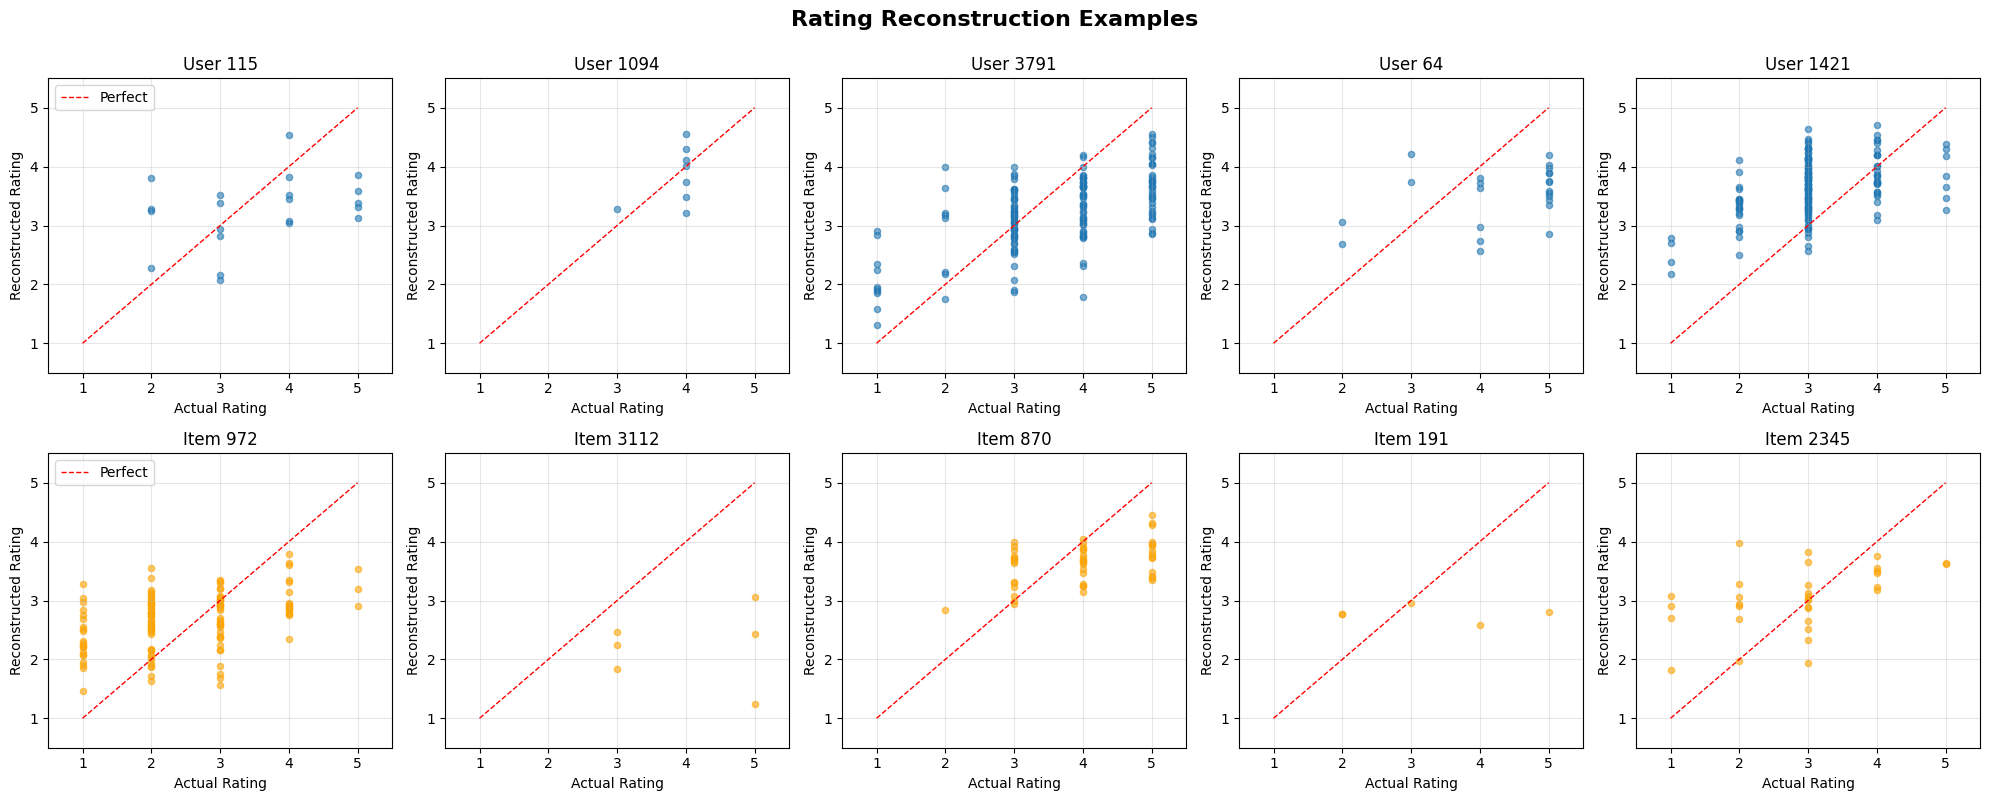


✓ Reconstruction evaluation complete!


In [ ]:
# ==================== RATING RECONSTRUCTION EVALUATION ====================

def evaluate_reconstruction(model, rating_matrix, device, num_samples=1000):
    """
    Evaluate the reconstruction quality of user and item rating vectors.
    
    Args:
        model: Trained HybridAutoRecNCF model
        rating_matrix: Full rating matrix (num_users, num_items)
        device: Device to run evaluation on
        num_samples: Number of users/items to sample for evaluation
    
    Returns:
        Dictionary with reconstruction metrics
    """
    model.eval()
    
    num_users, num_items = rating_matrix.shape
    
    # Sample users and items for evaluation
    user_indices = np.random.choice(num_users, min(num_samples, num_users), replace=False)
    item_indices = np.random.choice(num_items, min(num_samples, num_items), replace=False)
    
    user_recon_errors = []
    item_recon_errors = []
    user_recon_mae = []
    item_recon_mae = []
    
    # Create masks (1 where rating exists, 0 otherwise)
    user_mask = (rating_matrix > 0).astype(np.float32)
    item_mask = (rating_matrix.T > 0).astype(np.float32)
    
    with torch.no_grad():
        # Evaluate user reconstruction
        for user_id in tqdm(user_indices, desc="Evaluating user reconstruction", leave=False):
            user_vec = torch.FloatTensor(rating_matrix[user_id]).unsqueeze(0).to(device)
            user_mask_vec = torch.FloatTensor(user_mask[user_id]).unsqueeze(0).to(device)
            
            # Get reconstruction
            user_recon, _ = model.user_autorec(user_vec)
            
            # Calculate errors only for rated items
            mask_sum = user_mask_vec.sum().item()
            if mask_sum > 0:
                mse = ((user_recon - user_vec) ** 2 * user_mask_vec).sum().item() / mask_sum
                mae = (torch.abs(user_recon - user_vec) * user_mask_vec).sum().item() / mask_sum
                user_recon_errors.append(mse)
                user_recon_mae.append(mae)
        
        # Evaluate item reconstruction
        for item_id in tqdm(item_indices, desc="Evaluating item reconstruction", leave=False):
            item_vec = torch.FloatTensor(rating_matrix[:, item_id]).unsqueeze(0).to(device)
            item_mask_vec = torch.FloatTensor(item_mask[item_id]).unsqueeze(0).to(device)
            
            # Get reconstruction
            item_recon, _ = model.item_autorec(item_vec)
            
            # Calculate errors only for rated items
            mask_sum = item_mask_vec.sum().item()
            if mask_sum > 0:
                mse = ((item_recon - item_vec) ** 2 * item_mask_vec).sum().item() / mask_sum
                mae = (torch.abs(item_recon - item_vec) * item_mask_vec).sum().item() / mask_sum
                item_recon_errors.append(mse)
                item_recon_mae.append(mae)
    
    results = {
        'user_recon_rmse': np.sqrt(np.mean(user_recon_errors)) if user_recon_errors else 0.0,
        'user_recon_mae': np.mean(user_recon_mae) if user_recon_mae else 0.0,
        'item_recon_rmse': np.sqrt(np.mean(item_recon_errors)) if item_recon_errors else 0.0,
        'item_recon_mae': np.mean(item_recon_mae) if item_recon_mae else 0.0,
        'num_users_evaluated': len(user_recon_errors),
        'num_items_evaluated': len(item_recon_errors)
    }
    
    return results


# Load best model
print("=" * 70)
print("Loading Best Model for Reconstruction Evaluation")
print("=" * 70)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print(f"✓ Model loaded from: {model_path}")
print("=" * 70)

# Evaluate reconstruction on test set
print("\nEvaluating Rating Reconstruction Quality...")
print("=" * 70)

# Use test matrix for evaluation
recon_results = evaluate_reconstruction(model, test_mat, device, num_samples=1000)

print("\nReconstruction Evaluation Results:")
print("=" * 70)
print(f"User Reconstruction:")
print(f"  - RMSE: {recon_results['user_recon_rmse']:.4f}")
print(f"  - MAE:  {recon_results['user_recon_mae']:.4f}")
print(f"  - Users evaluated: {recon_results['num_users_evaluated']}")
print(f"\nItem Reconstruction:")
print(f"  - RMSE: {recon_results['item_recon_rmse']:.4f}")
print(f"  - MAE:  {recon_results['item_recon_mae']:.4f}")
print(f"  - Items evaluated: {recon_results['num_items_evaluated']}")
print("=" * 70)

# Sample rating reconstructions table
print("\n" + "=" * 70)
print("SAMPLE RATING RECONSTRUCTIONS — User & Item Reconstruction")
print("=" * 70)

# Get sample user-item pairs from test set
num_samples = 15
sample_pairs = test_df.sample(min(num_samples, len(test_df)), random_state=42)

user_recon_samples = []
item_recon_samples = []
actual_ratings = []

with torch.no_grad():
    for idx, row in sample_pairs.iterrows():
        user_id = int(row['user_id'])
        item_id = int(row['item_id'])
        actual_rating = float(row['rating'])
        
        # Get user reconstruction
        user_vec = torch.FloatTensor(test_mat[user_id]).unsqueeze(0).to(device)
        user_recon, _ = model.user_autorec(user_vec)
        user_recon_rating = user_recon.squeeze().cpu().numpy()[item_id]
        
        # Get item reconstruction
        item_vec = torch.FloatTensor(test_mat[:, item_id]).unsqueeze(0).to(device)
        item_recon, _ = model.item_autorec(item_vec)
        item_recon_rating = item_recon.squeeze().cpu().numpy()[user_id]
        
        user_recon_samples.append(user_recon_rating)
        item_recon_samples.append(item_recon_rating)
        actual_ratings.append(actual_rating)

# Create table
print(f"{'User':<8} {'Item':<8} {'Actual':<10} {'User Recon':<12} {'Item Recon':<12}")
print("-" * 70)

for i, (_, row) in enumerate(sample_pairs.iterrows()):
    user_id = int(row['user_id'])
    item_id = int(row['item_id'])
    actual = actual_ratings[i]
    user_recon = user_recon_samples[i]
    item_recon = item_recon_samples[i]
    
    print(f"{user_id:<8} {item_id:<8} {actual:<10.0f} {user_recon:<12.2f} {item_recon:<12.2f}")

print("=" * 70)

# Absolute errors table
print("\nAbsolute Errors (|Reconstructed - Actual|):")
print("-" * 70)
print(f"{'User':<8} {'Item':<8} {'Actual':<10} {'User Recon Error':<18} {'Item Recon Error':<18}")
print("-" * 70)

for i, (_, row) in enumerate(sample_pairs.iterrows()):
    user_id = int(row['user_id'])
    item_id = int(row['item_id'])
    actual = actual_ratings[i]
    user_error = abs(user_recon_samples[i] - actual)
    item_error = abs(item_recon_samples[i] - actual)
    
    print(f"{user_id:<8} {item_id:<8} {actual:<10.0f} {user_error:<18.2f} {item_error:<18.2f}")

print("=" * 70)

# Visualize some reconstruction examples
print("\nGenerating Reconstruction Examples...")
num_examples = 5

# Sample a few users for visualization
example_users = np.random.choice(num_users, min(num_examples, num_users), replace=False)
example_items = np.random.choice(num_items, min(num_examples, num_items), replace=False)

fig, axes = plt.subplots(2, num_examples, figsize=(4*num_examples, 8))

with torch.no_grad():
    # User reconstruction examples
    for idx, user_id in enumerate(example_users):
        user_vec = torch.FloatTensor(test_mat[user_id]).unsqueeze(0).to(device)
        user_mask = torch.FloatTensor((test_mat[user_id] > 0).astype(np.float32)).unsqueeze(0).to(device)
        
        user_recon, _ = model.user_autorec(user_vec)
        
        # Get only rated items for comparison
        rated_mask = user_mask.squeeze().cpu().numpy() > 0
        actual_ratings = user_vec.squeeze().cpu().numpy()[rated_mask]
        recon_ratings = user_recon.squeeze().cpu().numpy()[rated_mask]
        
        axes[0, idx].scatter(actual_ratings, recon_ratings, alpha=0.6, s=20)
        axes[0, idx].plot([1, 5], [1, 5], 'r--', linewidth=1, label='Perfect')
        axes[0, idx].set_xlabel('Actual Rating')
        axes[0, idx].set_ylabel('Reconstructed Rating')
        axes[0, idx].set_title(f'User {user_id}')
        axes[0, idx].grid(True, alpha=0.3)
        axes[0, idx].set_xlim([0.5, 5.5])
        axes[0, idx].set_ylim([0.5, 5.5])
        if idx == 0:
            axes[0, idx].legend()
    
    # Item reconstruction examples
    for idx, item_id in enumerate(example_items):
        item_vec = torch.FloatTensor(test_mat[:, item_id]).unsqueeze(0).to(device)
        item_mask = torch.FloatTensor((test_mat[:, item_id] > 0).astype(np.float32)).unsqueeze(0).to(device)
        
        item_recon, _ = model.item_autorec(item_vec)
        
        # Get only rated items for comparison
        rated_mask = item_mask.squeeze().cpu().numpy() > 0
        actual_ratings = item_vec.squeeze().cpu().numpy()[rated_mask]
        recon_ratings = item_recon.squeeze().cpu().numpy()[rated_mask]
        
        axes[1, idx].scatter(actual_ratings, recon_ratings, alpha=0.6, s=20, color='orange')
        axes[1, idx].plot([1, 5], [1, 5], 'r--', linewidth=1, label='Perfect')
        axes[1, idx].set_xlabel('Actual Rating')
        axes[1, idx].set_ylabel('Reconstructed Rating')
        axes[1, idx].set_title(f'Item {item_id}')
        axes[1, idx].grid(True, alpha=0.3)
        axes[1, idx].set_xlim([0.5, 5.5])
        axes[1, idx].set_ylim([0.5, 5.5])
        if idx == 0:
            axes[1, idx].legend()

plt.suptitle('Rating Reconstruction Examples', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n✓ Reconstruction evaluation complete!")
print("=" * 70)

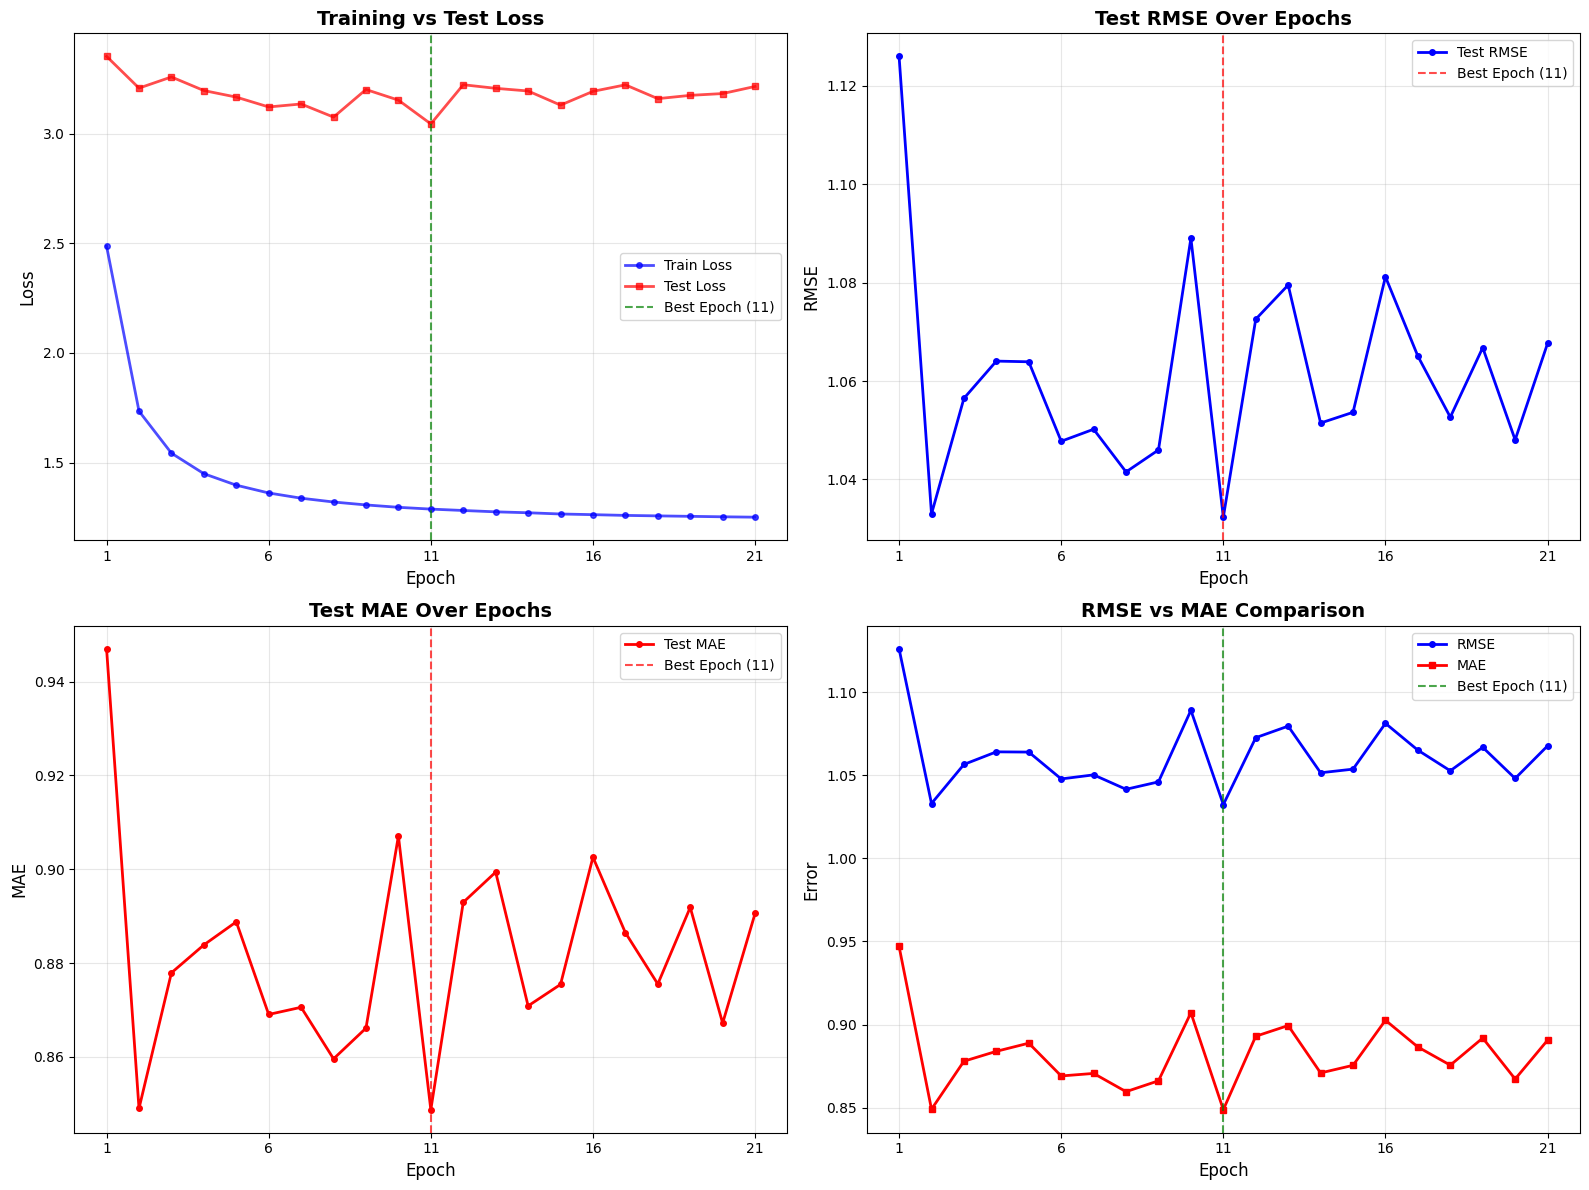

\nGenerating predictions for detailed analysis...


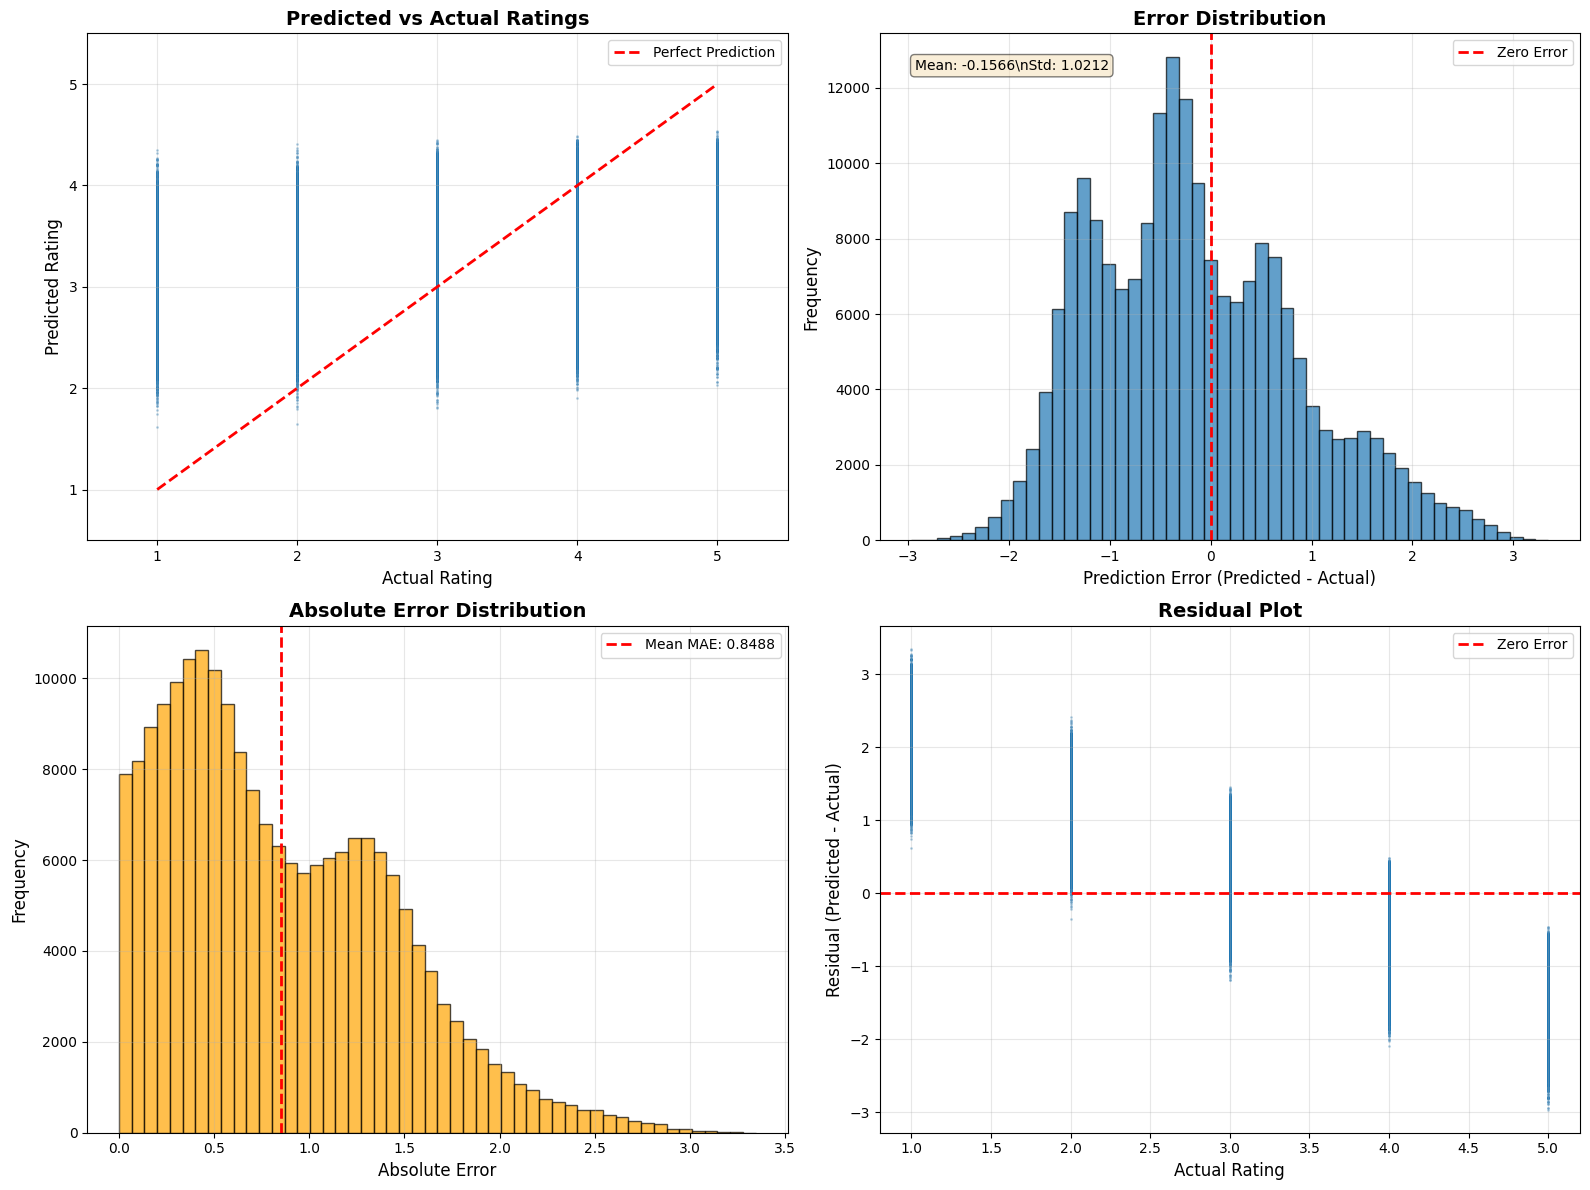

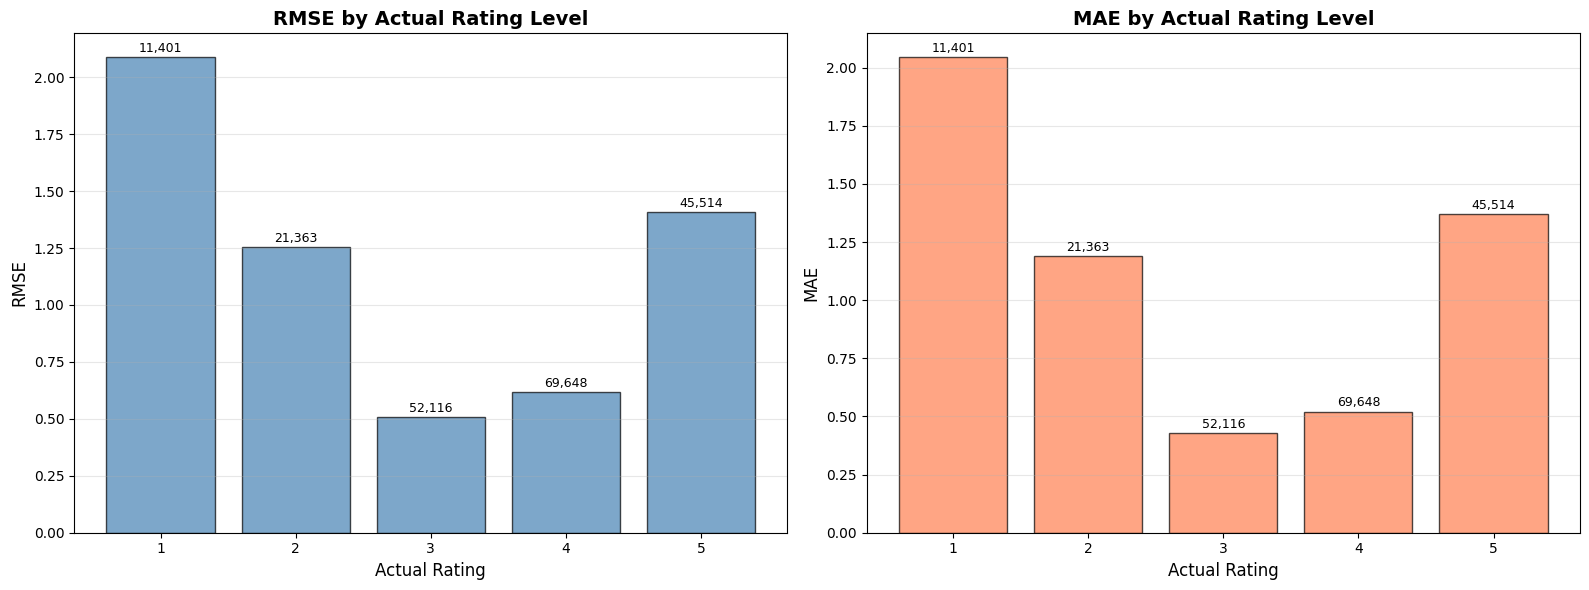

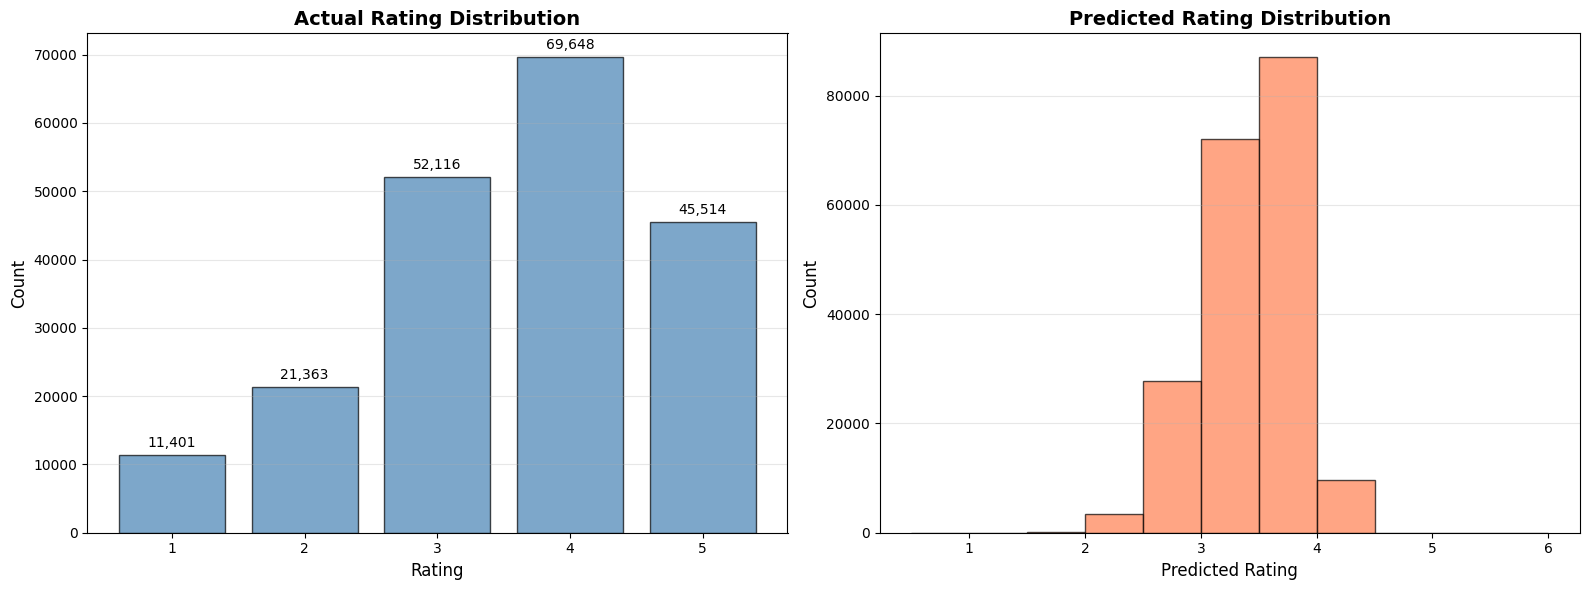

\n======================================================================
Final Training Metrics
Best RMSE: 1.0323 (Epoch 11)
Final RMSE: 1.0677
Final MAE: 0.8906
\nError Statistics:
  Mean Error: -0.1566
  Std Error: 1.0212
  Mean Absolute Error: 0.8488


In [ ]:
# ==================== COMPREHENSIVE VISUALIZATIONS ====================

# 1. Training and Test Loss Comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

epochs = training_history['epoch']

# Plot 1: Training vs Test Loss
axes[0, 0].plot(epochs, training_history['train_loss'], 'b-o', label='Train Loss', linewidth=2, markersize=4, alpha=0.7)
axes[0, 0].plot(epochs, training_history['test_loss'], 'r-s', label='Test Loss', linewidth=2, markersize=4, alpha=0.7)
axes[0, 0].axvline(x=best_epoch + 1, color='g', linestyle='--', alpha=0.7, label=f'Best Epoch ({best_epoch + 1})')
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('Training vs Test Loss', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()
axes[0, 0].set_xticks(epochs[::5] if len(epochs) > 10 else epochs)

# Plot 2: RMSE Over Epochs
axes[0, 1].plot(epochs, training_history['test_rmse'], 'b-o', label='Test RMSE', linewidth=2, markersize=4)
axes[0, 1].axvline(x=best_epoch + 1, color='r', linestyle='--', alpha=0.7, label=f'Best Epoch ({best_epoch + 1})')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('RMSE', fontsize=12)
axes[0, 1].set_title('Test RMSE Over Epochs', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()
axes[0, 1].set_xticks(epochs[::5] if len(epochs) > 10 else epochs)

# Plot 3: MAE Over Epochs
axes[1, 0].plot(epochs, training_history['test_mae'], 'r-o', label='Test MAE', linewidth=2, markersize=4)
axes[1, 0].axvline(x=best_epoch + 1, color='r', linestyle='--', alpha=0.7, label=f'Best Epoch ({best_epoch + 1})')
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('MAE', fontsize=12)
axes[1, 0].set_title('Test MAE Over Epochs', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()
axes[1, 0].set_xticks(epochs[::5] if len(epochs) > 10 else epochs)

# Plot 4: RMSE vs MAE Comparison
axes[1, 1].plot(epochs, training_history['test_rmse'], 'b-o', label='RMSE', linewidth=2, markersize=4)
axes[1, 1].plot(epochs, training_history['test_mae'], 'r-s', label='MAE', linewidth=2, markersize=4)
axes[1, 1].axvline(x=best_epoch + 1, color='g', linestyle='--', alpha=0.7, label=f'Best Epoch ({best_epoch + 1})')
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Error', fontsize=12)
axes[1, 1].set_title('RMSE vs MAE Comparison', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()
axes[1, 1].set_xticks(epochs[::5] if len(epochs) > 10 else epochs)

plt.tight_layout()
plt.show()

# 2. Get predictions for detailed analysis
print("\\nGenerating predictions for detailed analysis...")
model.load_state_dict(torch.load(model_path))
test_loss, test_rmse, test_mae, test_preds, test_ratings = evaluate(model, test_loader, device, return_predictions=True)

# 3. Predicted vs Actual Scatter Plot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Predicted vs Actual (Scatter)
axes[0, 0].scatter(test_ratings, test_preds, alpha=0.3, s=1)
axes[0, 0].plot([1, 5], [1, 5], 'r--', linewidth=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Rating', fontsize=12)
axes[0, 0].set_ylabel('Predicted Rating', fontsize=12)
axes[0, 0].set_title('Predicted vs Actual Ratings', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()
axes[0, 0].set_xlim([0.5, 5.5])
axes[0, 0].set_ylim([0.5, 5.5])

# Plot 2: Error Distribution
errors = test_preds - test_ratings
axes[0, 1].hist(errors, bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
axes[0, 1].set_xlabel('Prediction Error (Predicted - Actual)', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('Error Distribution', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()
mean_error = np.mean(errors)
std_error = np.std(errors)
axes[0, 1].text(0.05, 0.95, f'Mean: {mean_error:.4f}\\nStd: {std_error:.4f}', 
                transform=axes[0, 1].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 3: Absolute Error Distribution
abs_errors = np.abs(errors)
axes[1, 0].hist(abs_errors, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1, 0].axvline(x=np.mean(abs_errors), color='r', linestyle='--', linewidth=2, 
                  label=f'Mean MAE: {np.mean(abs_errors):.4f}')
axes[1, 0].set_xlabel('Absolute Error', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('Absolute Error Distribution', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()

# Plot 4: Residual Plot
axes[1, 1].scatter(test_ratings, errors, alpha=0.3, s=1)
axes[1, 1].axhline(y=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
axes[1, 1].set_xlabel('Actual Rating', fontsize=12)
axes[1, 1].set_ylabel('Residual (Predicted - Actual)', fontsize=12)
axes[1, 1].set_title('Residual Plot', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# 4. Per-Rating-Level Analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Calculate metrics per actual rating
rating_levels = [1, 2, 3, 4, 5]
rmse_per_rating = []
mae_per_rating = []
count_per_rating = []

for rating in rating_levels:
    mask = test_ratings == rating
    if np.sum(mask) > 0:
        preds_subset = test_preds[mask]
        ratings_subset = test_ratings[mask]
        rmse_per_rating.append(np.sqrt(np.mean((preds_subset - ratings_subset) ** 2)))
        mae_per_rating.append(np.mean(np.abs(preds_subset - ratings_subset)))
        count_per_rating.append(np.sum(mask))
    else:
        rmse_per_rating.append(0)
        mae_per_rating.append(0)
        count_per_rating.append(0)

# Plot 1: RMSE per Rating Level
x_pos = np.arange(len(rating_levels))
axes[0].bar(x_pos, rmse_per_rating, alpha=0.7, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Actual Rating', fontsize=12)
axes[0].set_ylabel('RMSE', fontsize=12)
axes[0].set_title('RMSE by Actual Rating Level', fontsize=14, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(rating_levels)
axes[0].grid(True, alpha=0.3, axis='y')
for i, (rmse, count) in enumerate(zip(rmse_per_rating, count_per_rating)):
    if count > 0:
        axes[0].text(i, rmse + 0.01, f'{count:,}', ha='center', va='bottom', fontsize=9)

# Plot 2: MAE per Rating Level
axes[1].bar(x_pos, mae_per_rating, alpha=0.7, color='coral', edgecolor='black')
axes[1].set_xlabel('Actual Rating', fontsize=12)
axes[1].set_ylabel('MAE', fontsize=12)
axes[1].set_title('MAE by Actual Rating Level', fontsize=14, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(rating_levels)
axes[1].grid(True, alpha=0.3, axis='y')
for i, (mae, count) in enumerate(zip(mae_per_rating, count_per_rating)):
    if count > 0:
        axes[1].text(i, mae + 0.01, f'{count:,}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# 5. Rating Distribution Comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Actual Rating Distribution
unique_ratings, counts = np.unique(test_ratings, return_counts=True)
axes[0].bar(unique_ratings, counts, alpha=0.7, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Rating', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Actual Rating Distribution', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')
for rating, count in zip(unique_ratings, counts):
    axes[0].text(rating, count + max(counts) * 0.01, f'{count:,}', ha='center', va='bottom', fontsize=10)

# Plot 2: Predicted Rating Distribution (binned)
pred_bins = np.arange(0.5, 6.5, 0.5)
axes[1].hist(test_preds, bins=pred_bins, alpha=0.7, color='coral', edgecolor='black')
axes[1].set_xlabel('Predicted Rating', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Predicted Rating Distribution', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print final metrics
print("\\n" + "=" * 70)
print("Final Training Metrics")
print("=" * 70)
print(f"Best RMSE: {best_test_rmse:.4f} (Epoch {best_epoch + 1})")
print(f"Final RMSE: {training_history['test_rmse'][-1]:.4f}")
print(f"Final MAE: {training_history['test_mae'][-1]:.4f}")
print(f"\\nError Statistics:")
print(f"  Mean Error: {mean_error:.4f}")
print(f"  Std Error: {std_error:.4f}")
print(f"  Mean Absolute Error: {np.mean(abs_errors):.4f}")
print("=" * 70)